In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets
import matplotlib.pyplot as plt
import models
import os

## Initialization

In [2]:
torch.manual_seed(42)
DATASET_PATH = "./data"
CHECKPOINT_PATH = "saved_models"

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True)
data_mean = (train_dataset.data / 255.0).mean(axis=(0, 1, 2))
data_std = (train_dataset.data / 255.0).std(axis=(0, 1, 2))

In [4]:
# Declare transformations
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std),
    ]
)

# No data augmentation for testing
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(data_mean, data_std)])

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True,
                                       download=True, transform=train_transform)

val_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True,
                                       download=True, transform=test_transform)

test_dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False,
                                       download=True, transform=test_transform)

train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000])


In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

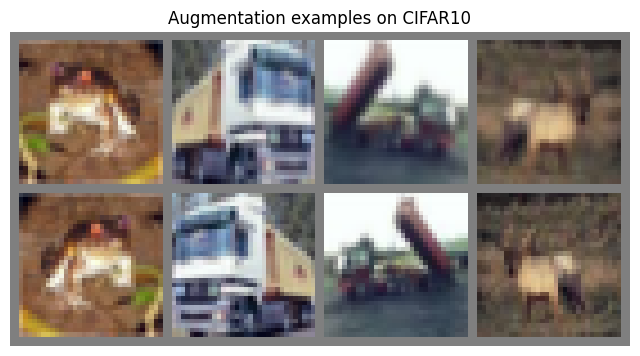

In [9]:
from PIL import Image

NUM_IMAGES = 4
images = [train_dataset[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_dataset.data[idx]) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Augmentation examples on CIFAR10")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [11]:
data_iter = iter(val_loader)

In [12]:
images_pack, labels_pack = next(data_iter)

## Linear Model Initialization

In [ ]:
import torch.optim as optim
import torch.nn as nn

lin_model = models.LinearModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(lin_model.parameters(), lr=0.001, momentum=0.9)

#### LM - Training

In [ ]:
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        optimizer.zero_grad()

        outputs = lin_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    
print("Training done.")

Training done.
Training done.
Training done.


#### LM - Save Trained Model

In [ ]:
torch.save(lin_model.state_dict(), os.path.join(CHECKPOINT_PATH, "linear_model.pth"))

#### LM - Loading Trainer Model

In [34]:
lin_model = models.LinearModel()
lin_model.load_state_dict(torch.load(os.path.join(CHECKPOINT_PATH, "linear_model.pth")))

<All keys matched successfully>

#### LM - Getting some outputs

In [ ]:
# results = lin_model(images[0].unsqueeze(0)) # Example code for 1 singular image given.
# _, prediction = torch.max(results, 1)
# print(classes[prediction])

results = lin_model(images_pack) # Example code for mini-batches from a iter object.

_, predictions = torch.max(results, 1)
print('Predicted: ', ' '.join(f'{classes[predictions[j]]:5s}'
                              for j in range(4)))

Predicted:  horse cat   car   ship 


## MLP - Initialization

In [29]:
mlp_model = models.MLP()

In [34]:
results = mlp_model(images_pack)

_, predictions = torch.max(results, 1)
print('Predicted: ', ' '.join(f'{classes[predictions[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   cat   deer  cat  


## Convolutional Neural Network - Initialization

In [25]:
from models import ConvolutionNetwork
cnn_model = models.ConvolutionNetwork(3, 3, 3, images_pack[0].size()[1])

In [26]:
results = cnn_model(images_pack)

_, predictions = torch.max(results, 1)
print('Predicted: ', ' '.join(f'{classes[predictions[j]]:5s}'
                              for j in range(4)))

RuntimeError: Given input size: (3x1x1). Calculated output size: (3x0x0). Output size is too small